In [ ]:
import matplotlib.pyplot as plt
from torch.optim.adamw import adamw
!pip install -q -U "tensorflow-text"
!pip install -q tf-models-official
!pip install transformers datasets torch scikit-learn
!pip install -U accelerate
!pip install -U transformers
!pip install -U evaluate
!pip install -U datasets huggingface_hub fsspec
!pip install -U scikit-learn

In [9]:
import datasets

tokenized_dataset_train = datasets.load_from_disk("tokenized_dataset_train").train_test_split(test_size=0.4)["test"]
tokenized_dataset_test = datasets.load_from_disk("tokenized_dataset_test").train_test_split(test_size=0.4)["test"]

# tokenized_dataset_train = tokenized_dataset_train.remove_columns(["tag", "lyrics"])
# tokenized_dataset_test = tokenized_dataset_test.remove_columns(["tag", "lyrics"])
tokenized_dataset_train = tokenized_dataset_train.remove_columns(["tag"])
tokenized_dataset_test = tokenized_dataset_test.remove_columns(["tag"])

In [10]:
from transformers import AutoModelForSequenceClassification

model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model_name_or_path="./result",num_labels=5)


In [11]:
# Freeze all layers except the classifier
for param in model.bert.parameters():
    param.requires_grad = False

# Keep only the classification head trainable
for param in model.classifier.parameters():
    param.requires_grad = True

print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

Trainable parameters: 3845


In [12]:
from transformers import TrainingArguments
import accelerate

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",  # Directory for saving model checkpoints
    eval_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",
    learning_rate=5e-5,  # Start with a small learning rate
    per_device_train_batch_size=1024,  # Batch size per GPU
    per_device_eval_batch_size=1024,
    # auto_find_batch_size=True,
    num_train_epochs=10,  # Number of epochs
    weight_decay=0.01,  # Regularization
    save_total_limit=2,  # Limit checkpoints to save space
    load_best_model_at_end=True,  # Automatically load the best checkpoint
    logging_dir="./logs",  # Directory for logs
    logging_steps=100,  # Log every 100 steps
    fp16=True  # Enable mixed precision for faster training
)

print(training_args)

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False

In [13]:
from transformers import Trainer
from evaluate import load

# Load a metric (F1-score in this case)
metric = load("f1")


# Define a custom compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return metric.compute(predictions=predictions, references=labels, average='weighted')

In [14]:
from transformers import AutoTokenizer

# Initialize the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [15]:
from torch.optim import AdamW
import transformers

no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped_parameters = [
    {
        "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
    {
        "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        "weight_decay": 0.0,
    },
]

data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer)
scheduler = transformers.get_scheduler(
    "linear",
    optimizer=AdamW(optimizer_grouped_parameters, lr=5e-05, eps=1e-08),
    num_warmup_steps=0,
    num_training_steps=len(tokenized_dataset_train) * training_args.num_train_epochs
)

trainer = Trainer(
    model=model,  # Pre-trained BERT model
    optimizers = (scheduler.optimizer,scheduler),
    args=training_args,  # Training arguments
    train_dataset=tokenized_dataset_train,
    eval_dataset=tokenized_dataset_test,
    tokenizer=tokenizer,
    data_collator=data_collator,  # Efficient batching
    compute_metrics=compute_metrics  # Custom metric
)

trainer.add_callback(transformers.EarlyStoppingCallback(early_stopping_patience=2))


/tmp/ipykernel_7726/418963040.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
predictions = trainer.predict(tokenized_dataset_test)
predicted_labels = predictions.predictions.argmax(axis=-1)


              precision    recall  f1-score   support

           0       0.08      0.75      0.14     13510
           1       0.39      0.36      0.37     56412
           2       0.12      0.34      0.17      8679
           3       0.60      0.14      0.23    113431
           4       0.84      0.40      0.54     79251

    accuracy                           0.30    271283
   macro avg       0.40      0.40      0.29    271283
weighted avg       0.58      0.30      0.34    271283



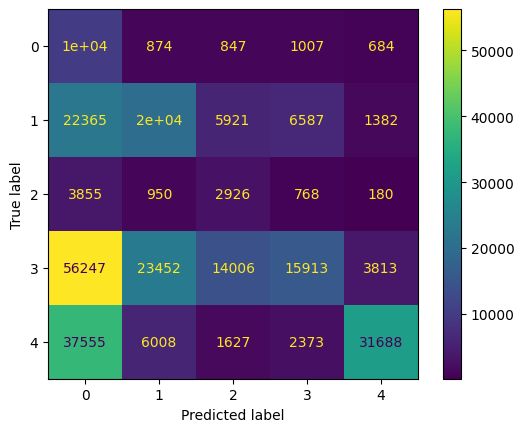

In [17]:
# Classification report
print(classification_report(tokenized_dataset_test["label"], predicted_labels))

# Confusion matrix
cm = confusion_matrix(tokenized_dataset_test["label"], predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()